In [ ]:
# === CELDA DE CONFIGURACIÓN WANDB (EJECUTAR PRIMERO) ===
import wandb
import os

# Pegar tu API key aquí
# WANDB_API_KEY = "619223e73ca0d6bb2a62fe224779121e4c7ebe1a"  # Reemplaza con tu API key de wandb
WANDB_API_KEY = "2348384a098c46310b56fea3a0ecc9c25d4ccd90"
def setup_wandb_online():
    """Configura Weights & Biases en modo online"""
    print("=== Configuración de Weights & Biases Online ===")

    # Configurar API key
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY

    # Intentar login
    try:
        wandb.login()

        # Verificar configuración con una prueba
        with wandb.init(
            project="butterfly-classification",
            name="test-connection",
            tags=["test"],
        ) as run:
            wandb.log({"connection_test": 1.0})

        print("\n✓ Conexión exitosa con wandb")
        print("✓ Login verificado")
        print("✓ Logging probado correctamente")
        print("\nWeights & Biases está configurado correctamente en modo online")

    except Exception as e:
        print(f"\n❌ Error al configurar wandb: {e}")
        print("Por favor, verifica tu API key y conexión a internet")
        raise e

# Ejecutar configuración
setup_wandb_online()



=== Configuración de Weights & Biases Online ===


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: juanemallma (juanemallma-tecnol-gico-de-costa-rica). Use `wandb login --relogin` to force relogin


connection_test,▁
connection_test,1



✓ Conexión exitosa con wandb
✓ Login verificado
✓ Logging probado correctamente

Weights & Biases está configurado correctamente en modo online


In [ ]:
# === CELDA 0: VERIFICACIÓN DEL ENTORNO ===
import sys
import torch
import os

def verify_environment():
    print("Verificando entorno...")

    # Verificar Python
    print(f"Python version: {sys.version}")

    # Verificar PyTorch y CUDA
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")

    # Verificar estructura del proyecto
    required_files = ['models.py', 'utils.py', 'conf/config.yaml']
    for file in required_files:
        if not os.path.exists(file):
            raise FileNotFoundError(f"Missing required file: {file}")

    # Verificar dataset
    if not os.path.exists('Butterfly-dataset'):
        raise FileNotFoundError("Dataset directory not found")

    print("\nEntorno verificado correctamente ✓")

verify_environment()

Verificando entorno...
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: Tesla T4

Entorno verificado correctamente ✓


In [ ]:
# ============= CELDA 1: IMPORTS Y CONFIGURACIÓN INICIAL =============
import os
import sys
from pathlib import Path

# Asegurar que los módulos locales están en el path
project_root = Path().absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Imports básicos
try:
    import torch
    import lightning as L
    import hydra
    import wandb
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from omegaconf import DictConfig, OmegaConf
    from datetime import datetime
    print("✓ Dependencias básicas importadas correctamente")
except ImportError as e:
    print(f"❌ Error importando dependencias básicas: {e}")
    print("Asegúrate de haber instalado todas las dependencias del requirements.txt")
    raise

# Importar módulos locales
try:
    from models import ButterflyAutoencoder, ButterflyClassifier, ButterflyDataModule
    from utils import (clean_gpu_memory, verify_dataset_structure, plot_confusion_matrix,
                      measure_inference_performance, plot_training_curves,
                      compare_model_variants, save_experiment_config)
    print("✓ Módulos locales importados correctamente")
except ImportError as e:
    print(f"❌ Error importando módulos locales: {e}")
    print("Verifica que estás ejecutando el notebook desde el directorio raíz del proyecto")
    raise

# Configurar warnings y reproducibilidad
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(42)

# Configurar estilo de visualización
plt.style.use('default')  # Usar estilo default primero
sns.set_style("whitegrid")  # Aplicar estilo de seaborn
sns.set_context("notebook")  # Ajustar contexto para notebook

# Verificar GPU y mostrar información del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nConfiguración del dispositivo:")
print(f"- Usando: {device}")
print(f"- CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"- GPU: {torch.cuda.get_device_name(0)}")
    print(f"- Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Verificar rutas críticas
print("\nVerificación de rutas:")
critical_paths = {
    'Modelos': 'models.py',
    'Utilidades': 'utils.py',
    'Configuración': 'conf/config.yaml',
    'Dataset': 'Butterfly-dataset'
}

for name, path in critical_paths.items():
    if os.path.exists(path):
        print(f"✓ {name}: {path}")
    else:
        print(f"❌ {name} no encontrado: {path}")

✓ Dependencias básicas importadas correctamente
✓ Módulos locales importados correctamente

Configuración del dispositivo:
- Usando: cuda
- CUDA disponible: True
- GPU: Tesla T4
- Memoria GPU total: 15.84 GB

Verificación de rutas:
✓ Modelos: models.py
✓ Utilidades: utils.py
✓ Configuración: conf/config.yaml
✓ Dataset: Butterfly-dataset


In [ ]:
# ============= CELDA 2: DEFINICIÓN DE CONFIGURACIONES =============

# Configuración base del experimento
BASE_CONFIG = {
    'seed': 42,
    'data_dir': 'Butterfly-dataset',
    'batch_size': 32,
    'num_workers': 4,
    'max_epochs': 100,
    'early_stopping_patience': 10,
}

# Configuración para experimento 70/30
CONFIG_70_30 = {
    'name': 'exp1_70_30',
    'description': 'Experiment with 70% unlabeled and 30% labeled data',
    'labeled_ratio': 0.3,
    'autoencoder': {
        'epochs': 50,
        'learning_rate': 1e-3,
        'weight_decay': 1e-5,
        'noise_factor': 0.1,
    },
    'classifier_variants': [
        {
            'name': 'from_scratch',
            'description': 'Classifier trained from scratch',
            'use_pretrained': False,
            'freeze_encoder': False,
            'learning_rate': 1e-3,
            'weight_decay': 1e-5,
        },
        {
            'name': 'pretrained_frozen',
            'description': 'Classifier with frozen pretrained encoder',
            'use_pretrained': True,
            'freeze_encoder': True,
            'learning_rate': 1e-3,
            'weight_decay': 1e-5,
        },
        {
            'name': 'pretrained_unfrozen',
            'description': 'Classifier with unfrozen pretrained encoder',
            'use_pretrained': True,
            'freeze_encoder': False,
            'learning_rate': 1e-4,
            'weight_decay': 1e-5,
        }
    ]
}

# Configuración para experimento 90/10
CONFIG_90_10 = {
    'name': 'exp1_90_10',
    'description': 'Experiment with 90% unlabeled and 10% labeled data',
    'labeled_ratio': 0.1,
    'autoencoder': {
        'epochs': 75,
        'learning_rate': 1e-3,
        'weight_decay': 1e-5,
        'noise_factor': 0.1,
    },
    'classifier_variants': CONFIG_70_30['classifier_variants']  # Mismas variantes
}

In [ ]:
# ============= CELDA 3: FUNCIONES DE ENTRENAMIENTO =============

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

def setup_wandb(config: dict, experiment_name: str, variant_name: str = None):
    """Configura Weights & Biases para el experimento"""
    try:
        with hydra.initialize_config_module(config_module="conf"):
            cfg = hydra.compose(config_name="config")
    except Exception as e:
        print(f"Warning: Could not load hydra config: {e}")
        # Configuración fallback
        cfg = {
            'wandb': {
                'project': "butterfly-classification",
                'entity': None,
                'tags': ["transfer-learning", "butterflies"]
            }
        }

    run_name = f"{experiment_name}_{variant_name}" if variant_name else experiment_name
    try:
        wandb.init(
            project=cfg['wandb']['project'],
            entity=cfg['wandb']['entity'],
            name=run_name,
            config={**config, **cfg},
            tags=cfg['wandb']['tags'] + [experiment_name],
            mode="online"  # o usa el valor de cfg si está disponible
        )
    except Exception as e:
        print(f"Warning: Could not initialize wandb: {e}")
        print("Continuing without wandb logging...")

def train_autoencoder(config: dict, datamodule: ButterflyDataModule) -> ButterflyAutoencoder:
    """Entrena el autoencoder"""
    print(f"\nTraining Autoencoder for {config['name']}")

    setup_wandb(config, f"autoencoder_{config['name']}")

    model = ButterflyAutoencoder(
        learning_rate=config['autoencoder']['learning_rate'],
        weight_decay=config['autoencoder']['weight_decay']
    )

    trainer = L.Trainer(
        max_epochs=config['autoencoder']['epochs'],
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=BASE_CONFIG['early_stopping_patience'],
                mode='min'
            ),
            ModelCheckpoint(
                monitor='val_loss',
                mode='min'
            )
        ]
    )

    trainer.fit(model,
               train_dataloaders=datamodule.train_dataloader(labeled=False),
               val_dataloaders=datamodule.val_dataloader())

    wandb.finish()
    return model

def train_classifier(config: dict,
                    variant_config: dict,
                    datamodule: ButterflyDataModule,
                    pretrained_encoder: torch.nn.Module = None) -> ButterflyClassifier:
    """Entrena una variante del clasificador"""
    print(f"\nTraining Classifier: {variant_config['name']}")

    setup_wandb(config, f"classifier_{config['name']}", variant_config['name'])

    model = ButterflyClassifier(
        num_classes=20,
        learning_rate=variant_config['learning_rate'],
        weight_decay=variant_config['weight_decay'],
        pretrained_encoder=pretrained_encoder if variant_config['use_pretrained'] else None,
        freeze_encoder=variant_config['freeze_encoder']
    )

    trainer = L.Trainer(
        max_epochs=BASE_CONFIG['max_epochs'],
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=BASE_CONFIG['early_stopping_patience'],
                mode='min'
            ),
            ModelCheckpoint(
                monitor='val_loss',
                mode='min'
            )
        ]
    )

    trainer.fit(model,
               train_dataloaders=datamodule.train_dataloader(labeled=True),
               val_dataloaders=datamodule.val_dataloader())

    # Evaluación
    test_results = trainer.test(model, datamodule.test_dataloader())[0]
    wandb.log({"test_results": test_results})

    # Matriz de confusión
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in datamodule.test_dataloader():
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    plot_confusion_matrix(
        y_true,
        y_pred,
        datamodule.get_class_names(),
        title=f"Confusion Matrix - {variant_config['name']}"
    )

    # Análisis de rendimiento
    perf_metrics = measure_inference_performance(model, datamodule.test_dataloader())
    wandb.log(perf_metrics)

    wandb.finish()
    return model, test_results, perf_metrics


In [ ]:

# ============= CELDA 4: FUNCIÓN PRINCIPAL DE EXPERIMENTO =============

def run_experiment(config: dict):
    """Ejecuta un experimento completo"""
    print(f"\nStarting experiment: {config['name']}")
    print(f"Description: {config['description']}")

    # Crear directorio para resultados
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = Path(f"outputs/{config['name']}_{timestamp}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Verificar dataset
    if not verify_dataset_structure(BASE_CONFIG['data_dir']):
        raise ValueError("Dataset structure is invalid")

    # Inicializar DataModule
    datamodule = ButterflyDataModule(
        data_dir=BASE_CONFIG['data_dir'],
        batch_size=BASE_CONFIG['batch_size'],
        num_workers=BASE_CONFIG['num_workers'],
        labeled_ratio=config['labeled_ratio']
    )
    datamodule.setup()

    # Entrenar autoencoder
    autoencoder = train_autoencoder(config, datamodule)
    clean_gpu_memory()

    # Entrenar variantes del clasificador
    results = []
    for variant_config in config['classifier_variants']:
        try:
            model, test_results, perf_metrics = train_classifier(
                config,
                variant_config,
                datamodule,
                pretrained_encoder=autoencoder.encoder if variant_config['use_pretrained'] else None
            )

            results.append({
                'variant': variant_config['name'],
                'test_accuracy': test_results['test_acc'],
                'test_f1': test_results['test_f1'],
                **perf_metrics
            })

            clean_gpu_memory()

        except Exception as e:
            print(f"Error training {variant_config['name']}: {e}")

    # Comparar resultados
    compare_model_variants(
        results,
        metrics=['test_accuracy', 'test_f1', 'avg_latency', 'model_size_mb'],
        save_dir=output_dir
    )

    # Guardar configuración
    save_experiment_config(config, output_dir)

    return results


Using device: cuda

Starting 70/30 experiment...

Starting experiment: exp1_70_30
Description: Experiment with 70% unlabeled and 30% labeled data

Training Autoencoder for exp1_70_30


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | UNetEncoder | 4.8 M  | train
1 | decoder | UNetDecoder | 3.0 M  | train
------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.338    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



Training Classifier: from_scratch


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Error training from_scratch: 'UNetEncoder' object has no attribute 'requires_grad'

Training Classifier: pretrained_frozen


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Error training pretrained_frozen: 'UNetEncoder' object has no attribute 'requires_grad'

Training Classifier: pretrained_unfrozen


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Error training pretrained_unfrozen: 'UNetEncoder' object has no attribute 'requires_grad'

Error in execution: Could not interpret value `variant` for `x`. An entry with this name does not appear in `data`.


Traceback (most recent call last):
  File "<ipython-input-10-c8dba5fe8e0d>", line 17, in main
    results_70_30 = run_experiment(CONFIG_70_30)
  File "<ipython-input-9-87285a067ee5>", line 54, in run_experiment
    compare_model_variants(
  File "/content/drive/MyDrive/Proyecto3-IA/utils.py", line 220, in compare_model_variants
    sns.barplot(data=df_results, x='variant', y=metric)
  File "/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py", line 2341, in barplot
    p = _CategoricalAggPlotter(
  File "/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py", line 67, in __init__
    super().__init__(data=data, variables=variables)
  File "/usr/local/lib/python3.10/dist-packages/seaborn/_base.py", line 634, in __init__
    self.assign_variables(data, variables)
  File "/usr/local/lib/python3.10/dist-packages/seaborn/_base.py", line 679, in assign_variables
    plot_data = PlotData(data, variables)
  File "/usr/local/lib/python3.10/dist-packages/seaborn/_core/data.py

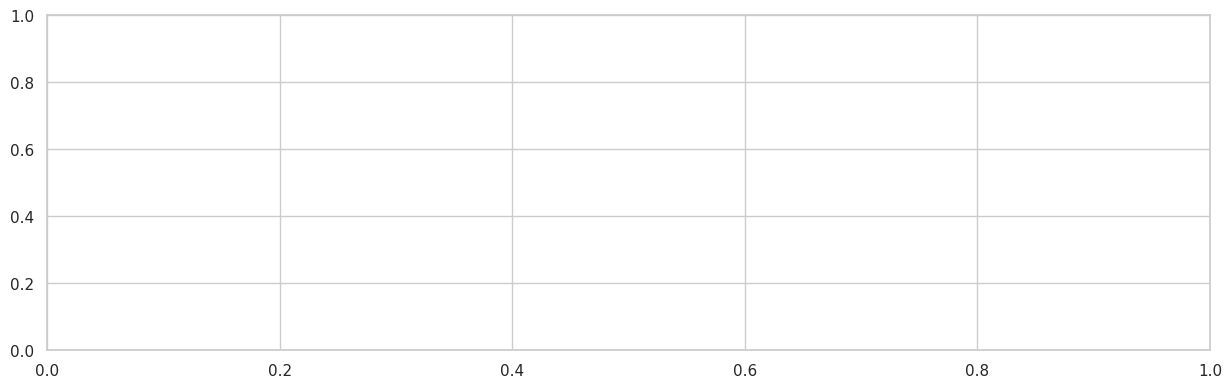

In [ ]:
# ============= CELDA 5: EJECUCIÓN DE EXPERIMENTOS =============

def main():
    """Función principal de ejecución"""
    try:
        # Verificar GPU y configurar reproducibilidad
        print(f"Using device: {device}")
        torch.manual_seed(BASE_CONFIG['seed'])

        # Configurar wandb
        if os.environ.get("WANDB_API_KEY") is None:
            print("WANDB: Running in offline mode")
            os.environ["WANDB_MODE"] = "offline"

        # Ejecutar experimento 70/30
        print("\nStarting 70/30 experiment...")
        results_70_30 = run_experiment(CONFIG_70_30)

        # Preguntar si continuar con 90/10
        response = input("\nContinue with 90/10 experiment? (y/n): ")
        if response.lower() == 'y':
            print("\nStarting 90/10 experiment...")
            results_90_10 = run_experiment(CONFIG_90_10)

    except KeyboardInterrupt:
        print("\nExperiment interrupted by user")
    except Exception as e:
        print(f"\nError in execution: {str(e)}")
        import traceback
        traceback.print_exc()
    finally:
        clean_gpu_memory()
        if wandb.run is not None:
            wandb.finish()

if __name__ == "__main__":
    main()



In [ ]:
# ============= CELDA 6 (OPCIONAL): ANÁLISIS DE RESULTADOS =============
# Esta celda se puede ejecutar después de completar los experimentos

def analyze_results():
    """Analiza y compara resultados de ambos experimentos"""
    results_dir = Path("outputs")

    # Encontrar los directorios más recientes para cada experimento
    exp_70_30_dir = sorted(results_dir.glob("exp1_70_30_*"))[-1]
    exp_90_10_dir = sorted(results_dir.glob("exp1_90_10_*"))[-1]

    # Cargar resultados
    results_70_30 = pd.read_csv(exp_70_30_dir / "model_comparison.csv")
    results_90_10 = pd.read_csv(exp_90_10_dir / "model_comparison.csv")

    # Comparar resultados
    plt.figure(figsize=(15, 10))

    metrics = ['test_accuracy', 'test_f1']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 1, i)

        x = np.arange(len(results_70_30))
        width = 0.35

        plt.bar(x - width/2, results_70_30[metric], width, label='70/30 split')
        plt.bar(x + width/2, results_90_10[metric], width, label='90/10 split')

        plt.xlabel('Model Variant')
        plt.ylabel(metric)
        plt.title(f'Comparison of {metric}')
        plt.xticks(x, results_70_30['variant'], rotation=45)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Para ejecutar el análisis:
# analyze_results()